# CTD casts

In [1]:
import glob
import numpy as np

import matplotlib.pyplot as plt

# cognac data and tools
import cognac.insitu as iu

In [2]:
if False:
    import os, sys, pickle, glob
    #import csv
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import copy

    import datetime

    import pandas as pd

    # cognac data and tools
    import cognac.insitu as iu

---

# load and clean data

In [3]:
# select campaign

#campaign = 'microco_leg2.yaml'
#campaign = 'lopstech19_leg1.yaml'
#campaign = 'lopstech19_leg2.yaml'
#campaign = 'cognac20'
campaign = 'sumos21'

cp = iu.campaign(campaign)

data_dir = cp['ctd']['path']
files = sorted(glob.glob(data_dir+'*.cnv'))

In [4]:
ctd = iu.ctd.ctd(files[0], columns=cp['ctd']['columns'])
ctd.d_time.head()
#(d['pressure'].diff()/d.dt).plot()

,timeJ,longitude,latitude,pressure,temperature,conductivity,salinity,altimeter,flag
time,,,,,,,,,
2021-03-03 19:03:50.125,62.794329,-7.18044,46.34034,-7.167,12.4036,0.000248,0.0070,0.0,0.0
2021-03-03 19:03:50.250,62.794330,-7.18044,46.34034,-7.167,12.4037,0.000233,0.0069,0.0,0.0
2021-03-03 19:03:50.375,62.794332,-7.18044,46.34034,-7.167,12.4047,0.000242,0.0070,0.0,0.0
2021-03-03 19:03:50.500,62.794333,-7.18044,46.34034,-7.167,12.4052,0.000242,0.0070,0.0,0.0
2021-03-03 19:03:50.625,62.794334,-7.18044,46.34034,-5.999,12.4054,0.000248,0.0070,0.0,0.0


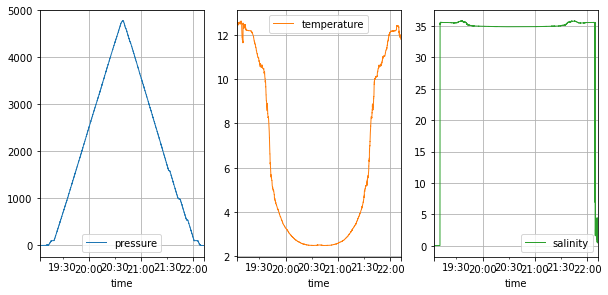

In [5]:
ctd.plot_tseries()

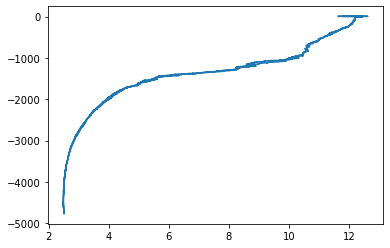

In [6]:
plt.figure()
plt.plot(ctd['temperature'],-ctd['pressure'],'-')

### resample temporally to 1 second data

In [7]:
ctd.resample('1S')

In [8]:
ctd.clean_and_depth_bin()

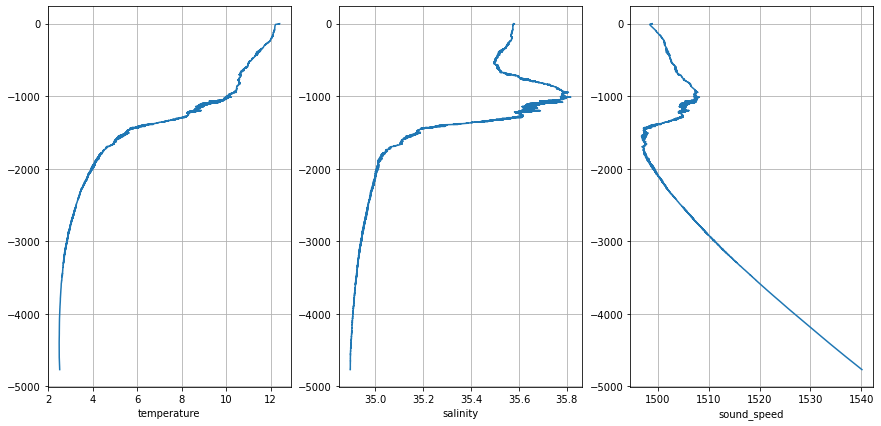

In [9]:
ctd.plot_depth()

In [10]:
ctd.plot_bk()

Loading BokehJS ...

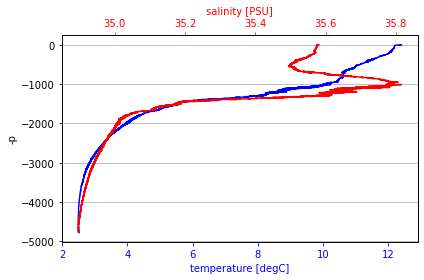

In [11]:
d = ctd.d_depth.reset_index()

fig, ax1 = plt.subplots()
ax1.plot(d['temperature'], -d['pressure'], 'b-')
ax1.set_xlabel('temperature [degC]', color='b')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('-p')
ax1.tick_params('x', colors='b')

ax2 = ax1.twiny()
ax2.plot(d['salinity'], -d['pressure'], 'r-')
ax2.set_xlabel('salinity [PSU]', color='r')
ax2.tick_params('x', colors='r')

ax1.yaxis.grid()
fig.tight_layout()
plt.show()


---
# process all casts

Data store to /Users/aponte/Current_projects/cognac/campagnes/2021_sumos/data/datap/ctd_d1.nc


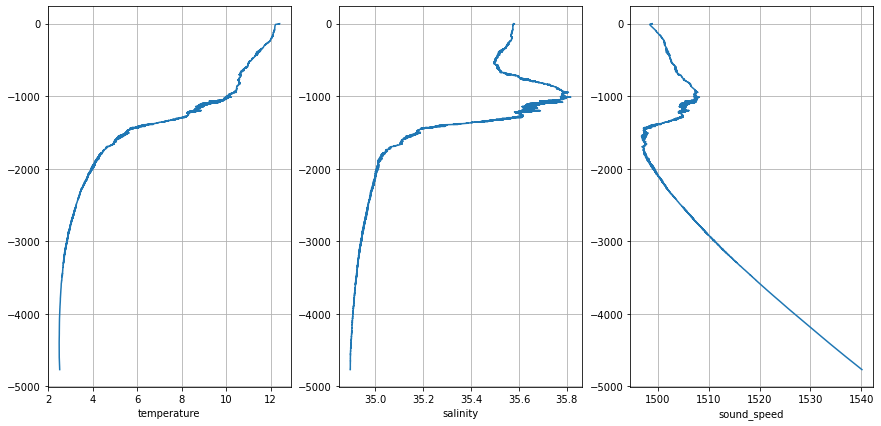

In [12]:
for c,  file in zip(cp['ctd'], files):
    d = iu.ctd.ctd(file, 
                   label=c.label,
                   columns=cp['ctd']['columns'],
                  )
    d.resample('1S')
    d.clean_and_depth_bin()
    d.plot_depth()
    #d.plot_bk()
    d.to_nc(cp.pathp+'ctd_%s.nc'%c.label)    

### reload data

---

# argo data

In [67]:
from argopy import DataFetcher as ArgoDataFetcher
import pandas as pd
import gsw

In [44]:
region = [-10, -2, 44, 48]
pressure = [0, 3000]
dates = ['2020', '2022']
ds = ArgoDataFetcher().region(region+pressure+dates).to_xarray()
ds = ds.argo.point2profile()

ds.argo.teos10(['SA', 'CT'])
ds['sound_speed'] = (('N_PROF','N_LEVELS'), gsw.sound_speed(ds.SA, ds.CT, ds.PRES))

In [45]:
ds_last = ds.TIME.groupby(ds.PLATFORM_NUMBER).max()
last_date = {f: ds_last.sel(PLATFORM_NUMBER=f).dt.strftime('%Y-%m-%d').values
             for f in ds_last.PLATFORM_NUMBER.values
            }
last_date

{3901943: array('2021-06-13', dtype=object),
 6902839: array('2020-09-01', dtype=object),
 6902840: array('2021-03-04', dtype=object),
 7900570: array('2021-06-07', dtype=object),
 7900573: array('2021-06-12', dtype=object)}

In [46]:
# print platform numbers
floats = set(ds.PLATFORM_NUMBER.values)
print(floats)

{6902839, 3901943, 6902840, 7900570, 7900573}


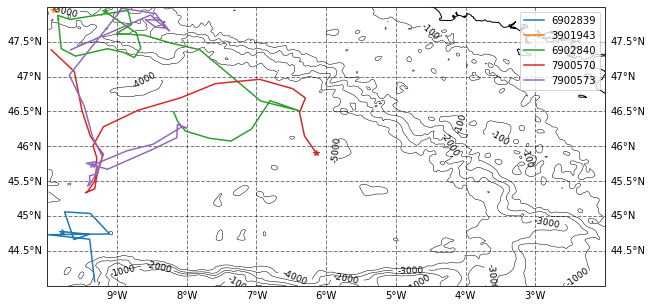

In [47]:
#fig, ax = plt.subplots(1, 1, figsize=(5,5))

fac = cp.plot_map(coast="10m", 
                  bounds=[-10, -2, 44, 48], 
                  levels=[-5000, -4000, -3000, -2000, -1000, -100],
                 )

ax = fac[1]

for f in floats:
    _ds = ds.where(ds.PLATFORM_NUMBER==f, drop=True)
    hdl = ax.plot(_ds.LONGITUDE, _ds.LATITUDE, label=str(f))
    ax.plot(_ds.LONGITUDE[-1], _ds.LATITUDE[-1], 
            color = hdl[0].get_c(), 
            marker='*',
           )
ax.legend()

3901943 [-9.90055833] [47.94999833]


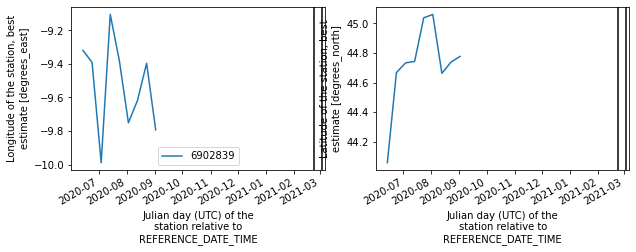

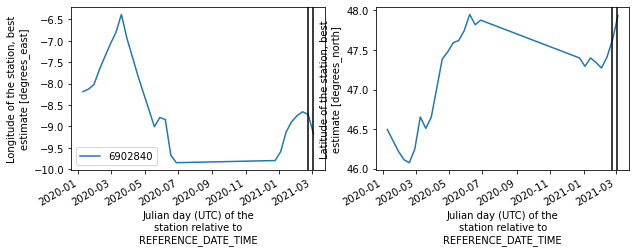

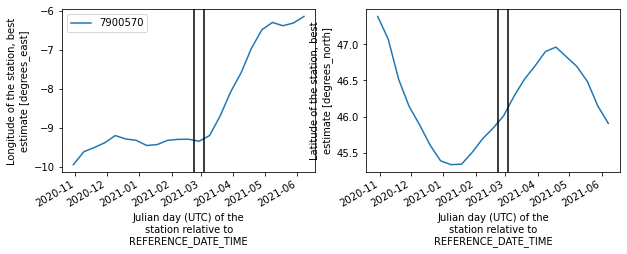

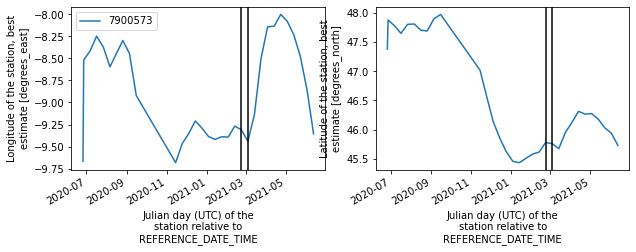

In [65]:
for f in floats:
    _ds = ds.where(ds.PLATFORM_NUMBER==f, drop=True)
    if _ds.N_PROF.size==1:
        print(f, _ds.LONGITUDE.values,  _ds.LATITUDE.values)
    else:
        fig, axes = plt.subplots(1,2, figsize=(10,3))
        ax = axes[0]
        _ds.LONGITUDE.plot(x="TIME", ax=axes[0], label=str(f))
        ax.legend()
        ax.axvline(cp.start, color='k')
        ax.axvline(cp.end, color='k')
        ax = axes[1]
        _ds.LATITUDE.plot(x="TIME", ax=ax)
        ax.axvline(cp.start, color='k')
        ax.axvline(cp.end, color='k')
        

In [77]:
dt = pd.Timedelta("10D")
_ds = ds.where( (ds.TIME > cp.start - dt)
               &(ds.TIME < cp.end + dt),
               drop=True
              )
print("Number of profiles within 10d: {}".format(_ds.N_PROF.size))

Number of profiles within 10d: 8


### store for later use

In [79]:
_ds.to_netcdf(cp.pathp+'argo.nc', mode="w")